In [2]:
# Cell 1 - system

import sys
sys.path.append('src')

from __future__ import annotations
import torch

from typing import Callable

import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torchdiffeq import odeint

import os
import re
from importlib.resources import files
from pathlib import Path

import numpy as np
import soundfile as sf
import tomli
from cached_path import cached_path

import cyrtranslit

from f5_tts.infer.utils_infer import (
    infer_single_process,
    load_model,
    load_vocoder,
    preprocess_ref_audio_text,
    preprocess_ref_audio_text_segment,
    remove_silence_for_generated_wav,
)


from f5_tts.model.utils import (
    default,
    exists,
    lens_to_mask,
    list_str_to_idx,
    list_str_to_tensor,
    mask_from_frac_lengths,
)

from f5_tts.model import DiT, UNetT

# Direct variable assignments instead of command line arguments
model = "F5-TTS"
# ckpt_file = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_dataset_ft_translit_pinyin/model_last.pt"
# ckpt_file = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_coarse_16nov/model_40000.pt"
ckpt_file = "/home/k4/Python/F5-TTS-Fork/ckpts/russian_coarse_16nov/model_0230.pt"

# Default configurations
config_path = os.path.join(files("f5_tts").joinpath("infer/examples/basic"), "basic.toml")
config = tomli.load(open(config_path, "rb"))

# Additional settings with default values
vocab_file = ""
output_dir = config["output_dir"]
remove_silence = config.get("remove_silence", False)
speed = 1.0
vocoder_name = "vocos"
load_vocoder_from_local = False
wave_path = Path(output_dir) / "infer_cli_out.wav"

# Vocoder settings
if vocoder_name == "vocos":
    vocoder_local_path = "../checkpoints/vocos-mel-24khz"
elif vocoder_name == "bigvgan":
    vocoder_local_path = "../checkpoints/bigvgan_v2_24khz_100band_256x"
mel_spec_type = vocoder_name

vocoder = load_vocoder(vocoder_name=mel_spec_type, is_local=load_vocoder_from_local, local_path=vocoder_local_path)

# Model configuration
if model == "F5-TTS":
    model_cls = DiT
    model_cfg = dict(dim=1024, depth=22, heads=16, ff_mult=2, text_dim=512, conv_layers=4)
    # if not ckpt_file:
    #     if vocoder_name == "vocos":
    #         repo_name = "F5-TTS"
    #         exp_name = "F5TTS_Base"
    #         ckpt_step = 1200000
    #         ckpt_file = str(cached_path(f"hf://SWivid/{repo_name}/{exp_name}/model_{ckpt_step}.safetensors"))
    #     elif vocoder_name == "bigvgan":
    #         repo_name = "F5-TTS"
    #         exp_name = "F5TTS_Base_bigvgan"
    #         ckpt_step = 1250000
    #         ckpt_file = str(cached_path(f"hf://SWivid/{repo_name}/{exp_name}/model_{ckpt_step}.pt"))


ema_model = load_model(model_cls, model_cfg, ckpt_file, mel_spec_type=vocoder_name, vocab_file=vocab_file)

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/k4/Python/F5-TTS-Fork/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-20 01:51:38,319 - INFO - PyTorch version 2.5.1+cu121 available.


Download Vocos from huggingface charactr/vocos-mel-24khz


/home/k4/Python/F5-TTS-Fork/.venv/lib/python3.10/site-packages/vocos/pretrained.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_


vocab :  /home/k4/Python/F5-TTS-Fork/src/f5_tts/infer/examples/vocab.txt
tokenizer :  custom
model :  /home/k4/Python/F5-TTS-Fork/ckpts/russian_coarse_16nov/model_0230.pt 



In [3]:
# Cell 2 - defining main process (inference process)

import librosa
import librosa.display
import matplotlib.pyplot as plt

def save_mel_spectrogram(audio_path, save_path, title):
    y, sr = librosa.load(audio_path, sr=None)  # Load audio
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale

    # Plot and save the mel-spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", fmax=8000, cmap="magma")
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


def main_process(ref_audio, ref_text, text_gen, model_obj, mel_spec_type, remove_silence, speed, end_time=None,cfg_strength=2.0, nfe_step=32, start_step=0, end_step=32):
    # Single voice configuration
    main_voice = {"ref_audio": ref_audio, "ref_text": ref_text}
    ref_audio, ref_text = preprocess_ref_audio_text_segment(main_voice["ref_audio"], main_voice["ref_text"], end_time=end_time, clip_short=False, bypass_cache=True)
    print("Ref_audio:", ref_audio)
    print("Ref_text:", ref_text)

    # Generate audio
    audio, final_sample_rate, _, trajectory = infer_single_process(
        ref_audio, ref_text, text_gen, model_obj, vocoder, mel_spec_type=mel_spec_type, nfe_step=nfe_step, cfg_strength=cfg_strength, speed=speed, start_step=start_step, end_step=end_step
    )

    # Save the generated wave
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with open(wave_path, "wb") as f:
        sf.write(f.name, audio, final_sample_rate)
        if remove_silence:
            remove_silence_for_generated_wav(f.name)
        print(f"Saved generated audio to {f.name}")

    # Save mel-spectrograms
    ref_mel_path = Path(output_dir) / "ref_mel.png"
    gen_mel_path = Path(output_dir) / "gen_mel.png"

    save_mel_spectrogram(ref_audio, ref_mel_path, "Reference Audio Mel-Spectrogram")
    save_mel_spectrogram(wave_path, gen_mel_path, "Generated Audio Mel-Spectrogram")

    return trajectory


### Настройки генерации

In [4]:
# Cell 3 - loading Russian songs dataset

from russian_songs_dataset_utils import process_music_ref_dataset

base_ref_tracks = process_music_ref_dataset("/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb", cache_filename="ref_data_cache.json")
print(f"found {len(base_ref_tracks)} base tracks with lyrics")

Loading cached data from ref_data_cache.json
found 766 base tracks with lyrics


In [5]:
# Cell 4 - test printing queries from Russian songs dataset

ref_track_name = list(base_ref_tracks.keys())[515]
ref_track = base_ref_tracks[ref_track_name]
print(ref_track_name)
print(ref_track['mir'])
print(ref_track['caption'])
print(ref_track['mir_data']['bpm'])
print(f"how many sections: {len(ref_track['sections'])}")
print(ref_track['sections'][0]['words'])
print(ref_track['sections'][0]['mp3_path'])

03.Encelt - Дикая охота
/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb/Encelt/Истории у костра [2017]/03.Encelt - Дикая охота.mir.json
﻿Женский голос, отчётливый, легенды, фолк, рок, мюзикл, эпичный
140
how many sections: 7
Между небом и землёй в дикой ясоте Слышишь ветер вой на протяжной ноте Мчатся вихрем в ночи,
/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb/Encelt/Истории у костра [2017]/03.Encelt - Дикая охота_vocals_stretched_120bpm_section2.mp3


In [12]:
# Cell 5 - acquiring relevant data from the dataset and setting a query phrase

# # ref_audio = "src/f5_tts/infer/examples/basic/basic_ref_en.wav"
# # ref_audio = "/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb/Tesla Boy/Андропов [2020]/05.Tesla Boy - Ватикан_vocals_stretched_120bpm_section5.mp3"
# # ref_text = "Prosti moi drug, prosti moi drug, ne opravdal, ne opravdal, instinkti vrut, instinkti vrut, ya vidishny, kreatariseksual"
# ref_audio = "/media/k4_nas/Datasets/Music_RU/Vocal_Dereverb/Tesla Boy/Андропов [2020]/05.Tesla Boy - Ватикан_vocals_stretched_120bpm_section5.mp3"
# ref_text = "Prosti moi drug, prosti moi drug, ne opravdal, ne opravdal, instinkti vrut, instinkti vrut, ya vidishny, kreatariseksual"
# # gen_text = "nichego na svete luchshe netu, chem brodit' druz'jam po belu svetu. tem, kto druzhen, ne strashny trevogi. nam ljubye dorogi dorogi"
# # gen_text = "nichego na svete luchshe netu, chem brodit' druz'jam po belu svetu."

def get_text_audio_and_end_time_path_for_ref(ref_id, section_num, base_ref_tracks):
    ref_track = base_ref_tracks[list(base_ref_tracks.keys())[ref_id]]
    words = ref_track['sections'][section_num]['words']
    mp3_path =ref_track['sections'][section_num]['mp3_path']
    return cyrtranslit.to_latin(words, "ru").lower(), mp3_path, ref_track['sections'][section_num]['end_time']

def to_translit(text):
    return cyrtranslit.to_latin(text, "ru").lower()

# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(80, 1, base_ref_tracks) # 80 плохой
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(105, 2, base_ref_tracks) # тут нужна скорость 0.1
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(500, 2, base_ref_tracks) # тут нужна скорость 0.3
ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(600, 0, base_ref_tracks) # монеточка,  скорость 0.3
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(630, 0, base_ref_tracks) # какой-то женский шансон,  скорость 0.3
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(638, 0, base_ref_tracks) #  скорость 0.6
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(640, 0, base_ref_tracks) # Этот всё выговаривает, скорость 0.5
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(645, 0, base_ref_tracks) #  скорость 0.7
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(648, 0, base_ref_tracks) #  скорость 0.7
# ref_text, ref_audio = get_text_audio_and_end_time_path_for_ref(680, 0, base_ref_tracks) # рэп, скорость 0.9
# ref_text, ref_audio, ref_end_time = get_text_audio_and_end_time_path_for_ref(360, 0, base_ref_tracks) # 

# gen_text = to_translit("Эх, полным полна коробочка! Есть в ней ситец и парча. Пожалей, душа-зазнобушка молодецкого плеча")
# gen_text = to_translit("О-о-о-о, зеленоеглазое такси. О-о-о-о, притормози, притормози! О-о-о-о, ты отвези меня туда! О-о-о-о, где будут рады мне всегда! ")
# gen_text = to_translit("Ты сидишь на стуле с голым торсом, я смотрю на пиццу, у меня вопросы.")
gen_text = to_translit("Привет, Дилан. Дилан, привет")
# gen_text = to_translit("Эх, полным полна коробочка!")

### Простая генерация

Symbols in ref text: 111
Symbols in gen text: 28
Converting audio...
Ref_audio: /tmp/tmpiyv9mya4.wav
Ref_text: esli b mne platili kazhdy'j raz kazhdy'j raz, kogda ya dumayu o tebe ya by' bomzhevala vozle trass ya by' stala
Saved generated audio to tests/infer_cli_out.wav
111


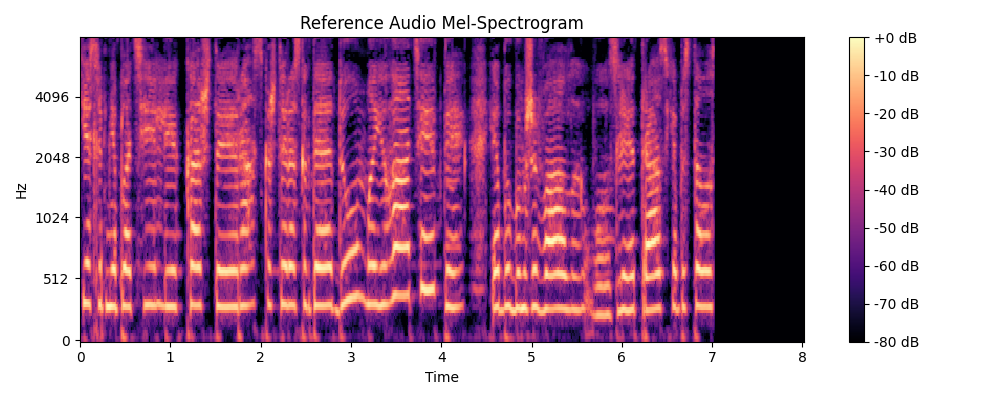

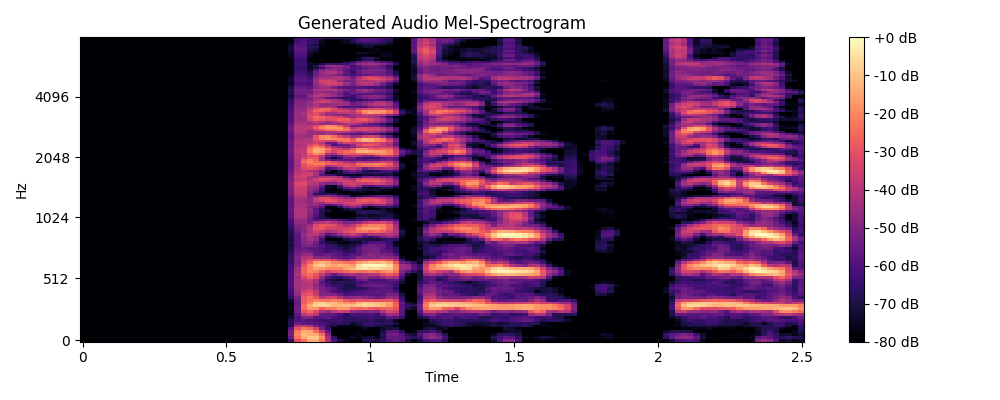

In [13]:
# Cell 6 - main process call & visualization, simple processing
speed = 0.8
print(f"Symbols in ref text: {len(ref_text)}")
print(f"Symbols in gen text: {len(gen_text)}")
main_process(ref_audio, ref_text, gen_text, ema_model, mel_spec_type, remove_silence, speed, end_time=ref_end_time, nfe_step=32, cfg_strength=3.0)
print(len(ref_text))

# Display mel-spectrograms
from IPython.display import display, Image, Audio

ref_mel_path = Path(output_dir) / "ref_mel.png"
gen_mel_path = Path(output_dir) / "gen_mel.png"

display(Image(filename=ref_mel_path))
display(Image(filename=gen_mel_path))

# Display audio
display(Audio(ref_audio))
display(Audio(wave_path))

### Step-wise generation, noise removal

Converting audio...
Audio is over 15s, clipping short. (2)
Using custom reference text...


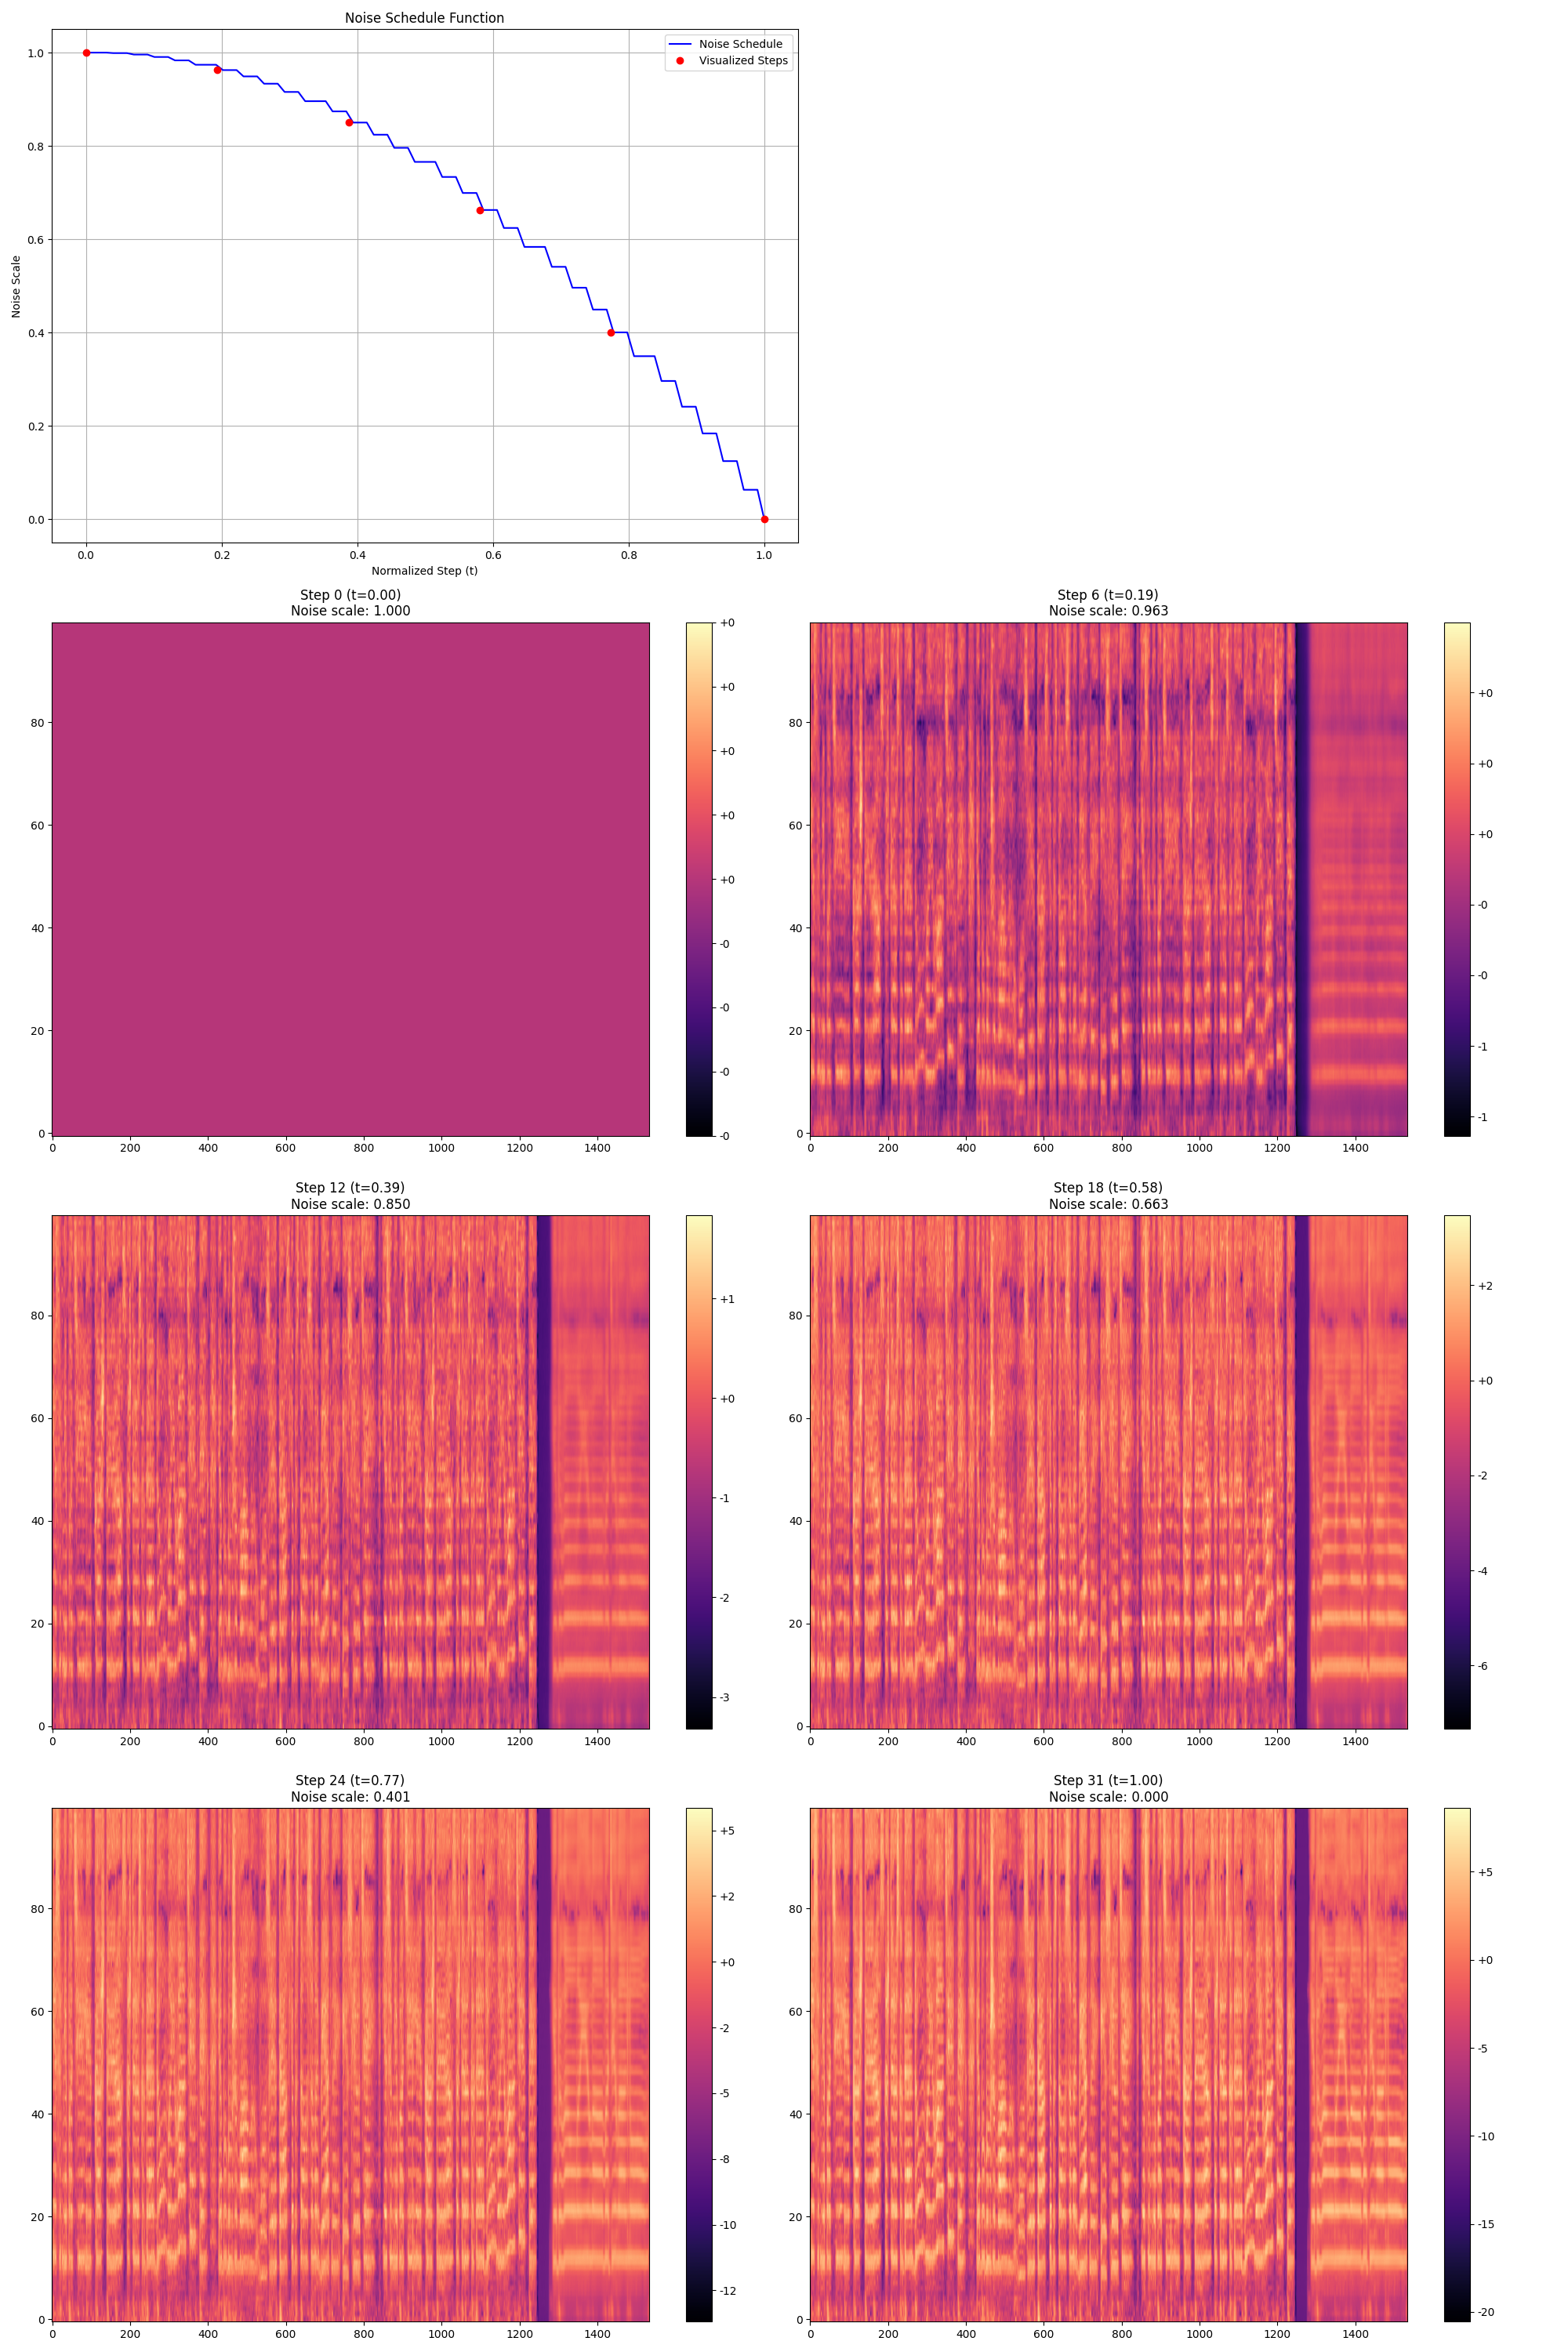


Audio at different steps:

Step 0 (t=0.00):


RuntimeError: Calculated padded input size per channel: (6). Kernel size: (7). Kernel size can't be greater than actual input size

In [8]:
# Cell 7 - visualizing noise schedule and step-by-step generation

# Import needed at the top of the cell
from IPython.display import display, Image, Audio
import torchaudio

# Constants (matching the ones from utils.py)
target_sample_rate = 24000
hop_length = 256
target_rms = 0.1

def get_noise_schedule(step: int, total_steps: int) -> float:
    """
    Returns noise scale for a given step.
    """
    t = step / (total_steps - 1)
    return 1 - (t) ** 2

def clean_mel_at_step(trajectory: torch.Tensor, step_idx: int, ref_audio_len: int, 
                     vocoder, mel_spec_type: str, target_rms: float, device) -> np.ndarray:
    """
    Clean mel-spectrogram at given step and convert to audio
    """
    total_steps = len(trajectory)
    initial_noise = trajectory[0]
    noise_scale = get_noise_schedule(step_idx, total_steps)
    
    # Clean the mel-spectrogram
    cleaned_mel = trajectory[step_idx] - initial_noise * noise_scale
    
    # Process for audio generation
    cleaned_mel = cleaned_mel.to(torch.float32)
    cleaned_mel = cleaned_mel[:, ref_audio_len:, :]
    cleaned_mel_spec = cleaned_mel.permute(0, 2, 1)
    
    # Ensure everything is on the right device
    cleaned_mel_spec = cleaned_mel_spec.to(device)
    vocoder = vocoder.to(device)
        
    # Generate audio
    if mel_spec_type == "vocos":
        generated_wave = vocoder.decode(cleaned_mel_spec)
    elif mel_spec_type == "bigvgan":
        generated_wave = vocoder(cleaned_mel_spec)
        
    if target_rms is not None:
        current_rms = torch.sqrt(torch.mean(torch.square(generated_wave)))
        if current_rms < target_rms:
            generated_wave = generated_wave * target_rms / current_rms
            
    return generated_wave.squeeze().cpu().numpy()

# Parameters
speed = 0.5
num_vis_steps = 6

# Preprocess reference audio/text
main_voice = {"ref_audio": ref_audio, "ref_text": ref_text}
ref_audio_preprocessed, ref_text_preprocessed = preprocess_ref_audio_text(main_voice["ref_audio"], main_voice["ref_text"])

# Get reference audio length
audio, sr = torchaudio.load(ref_audio_preprocessed)
ref_audio_len = audio.shape[-1] // hop_length

# Generate full trajectory
audio, sr, mel_spec, trajectory = infer_single_process(
    ref_audio_preprocessed, ref_text_preprocessed, gen_text, ema_model, vocoder, 
    mel_spec_type=mel_spec_type, 
    nfe_step=32,
    speed=speed
)

# Create figure for spectrograms
plt.figure(figsize=(20, 30))

# First, plot the noise schedule
plt.subplot(4, 2, 1)
x = np.linspace(0, 1, 100)
y = [get_noise_schedule(int(t * (len(trajectory)-1)), len(trajectory)) for t in x]
plt.plot(x, y, 'b-', label='Noise Schedule')
plt.grid(True)
plt.xlabel('Normalized Step (t)')
plt.ylabel('Noise Scale')
plt.title('Noise Schedule Function')

# Add points for the steps we're visualizing
trajectory_len = len(trajectory)
step_indices = np.linspace(0, trajectory_len-1, num_vis_steps).astype(int)
step_times = step_indices / (trajectory_len-1)
step_values = [get_noise_schedule(step_idx, trajectory_len) for step_idx in step_indices]
plt.plot(step_times, step_values, 'ro', label='Visualized Steps')
plt.legend()

# Plot spectrograms
for i, step_idx in enumerate(step_indices):
    plt.subplot(4, 2, i + 3)
    noise_scale = get_noise_schedule(step_idx, trajectory_len)
    step_mel = trajectory[step_idx].squeeze().cpu().numpy() - \
               trajectory[0].squeeze().cpu().numpy() * noise_scale
    
    plt.imshow(step_mel.T, aspect='auto', origin='lower', cmap='magma')
    plt.colorbar(format='%+2.0f')
    plt.title(f'Step {step_idx} (t={step_idx/(trajectory_len-1):.2f})\nNoise scale: {noise_scale:.3f}')

# Save and display the plot
combined_spec_path = Path(output_dir) / "trajectory_steps.png"
plt.tight_layout()
plt.savefig(combined_spec_path)
plt.close()

# Display the plot
display(Image(filename=combined_spec_path))

# Generate and display audio for each cleaned step
print("\nAudio at different steps:")
for step_idx in step_indices:
    print(f"\nStep {step_idx} (t={step_idx/(trajectory_len-1):.2f}):")
    cleaned_audio = clean_mel_at_step(
        trajectory, step_idx, ref_audio_len, vocoder, 
        mel_spec_type, target_rms, device
    )
    
    # Save and play with correct sample rate
    step_wave_path = Path(output_dir) / f"step_{step_idx}_audio.wav"
    sf.write(step_wave_path, cleaned_audio, target_sample_rate)  # Use correct sample rate
    display(Audio(step_wave_path))

Converting audio...
Using custom reference text...
Generating initial trajectory...

Generating 4 new samples from intermediate state...
Generating sample 1/4
Generating sample 2/4
Generating sample 3/4
Generating sample 4/4


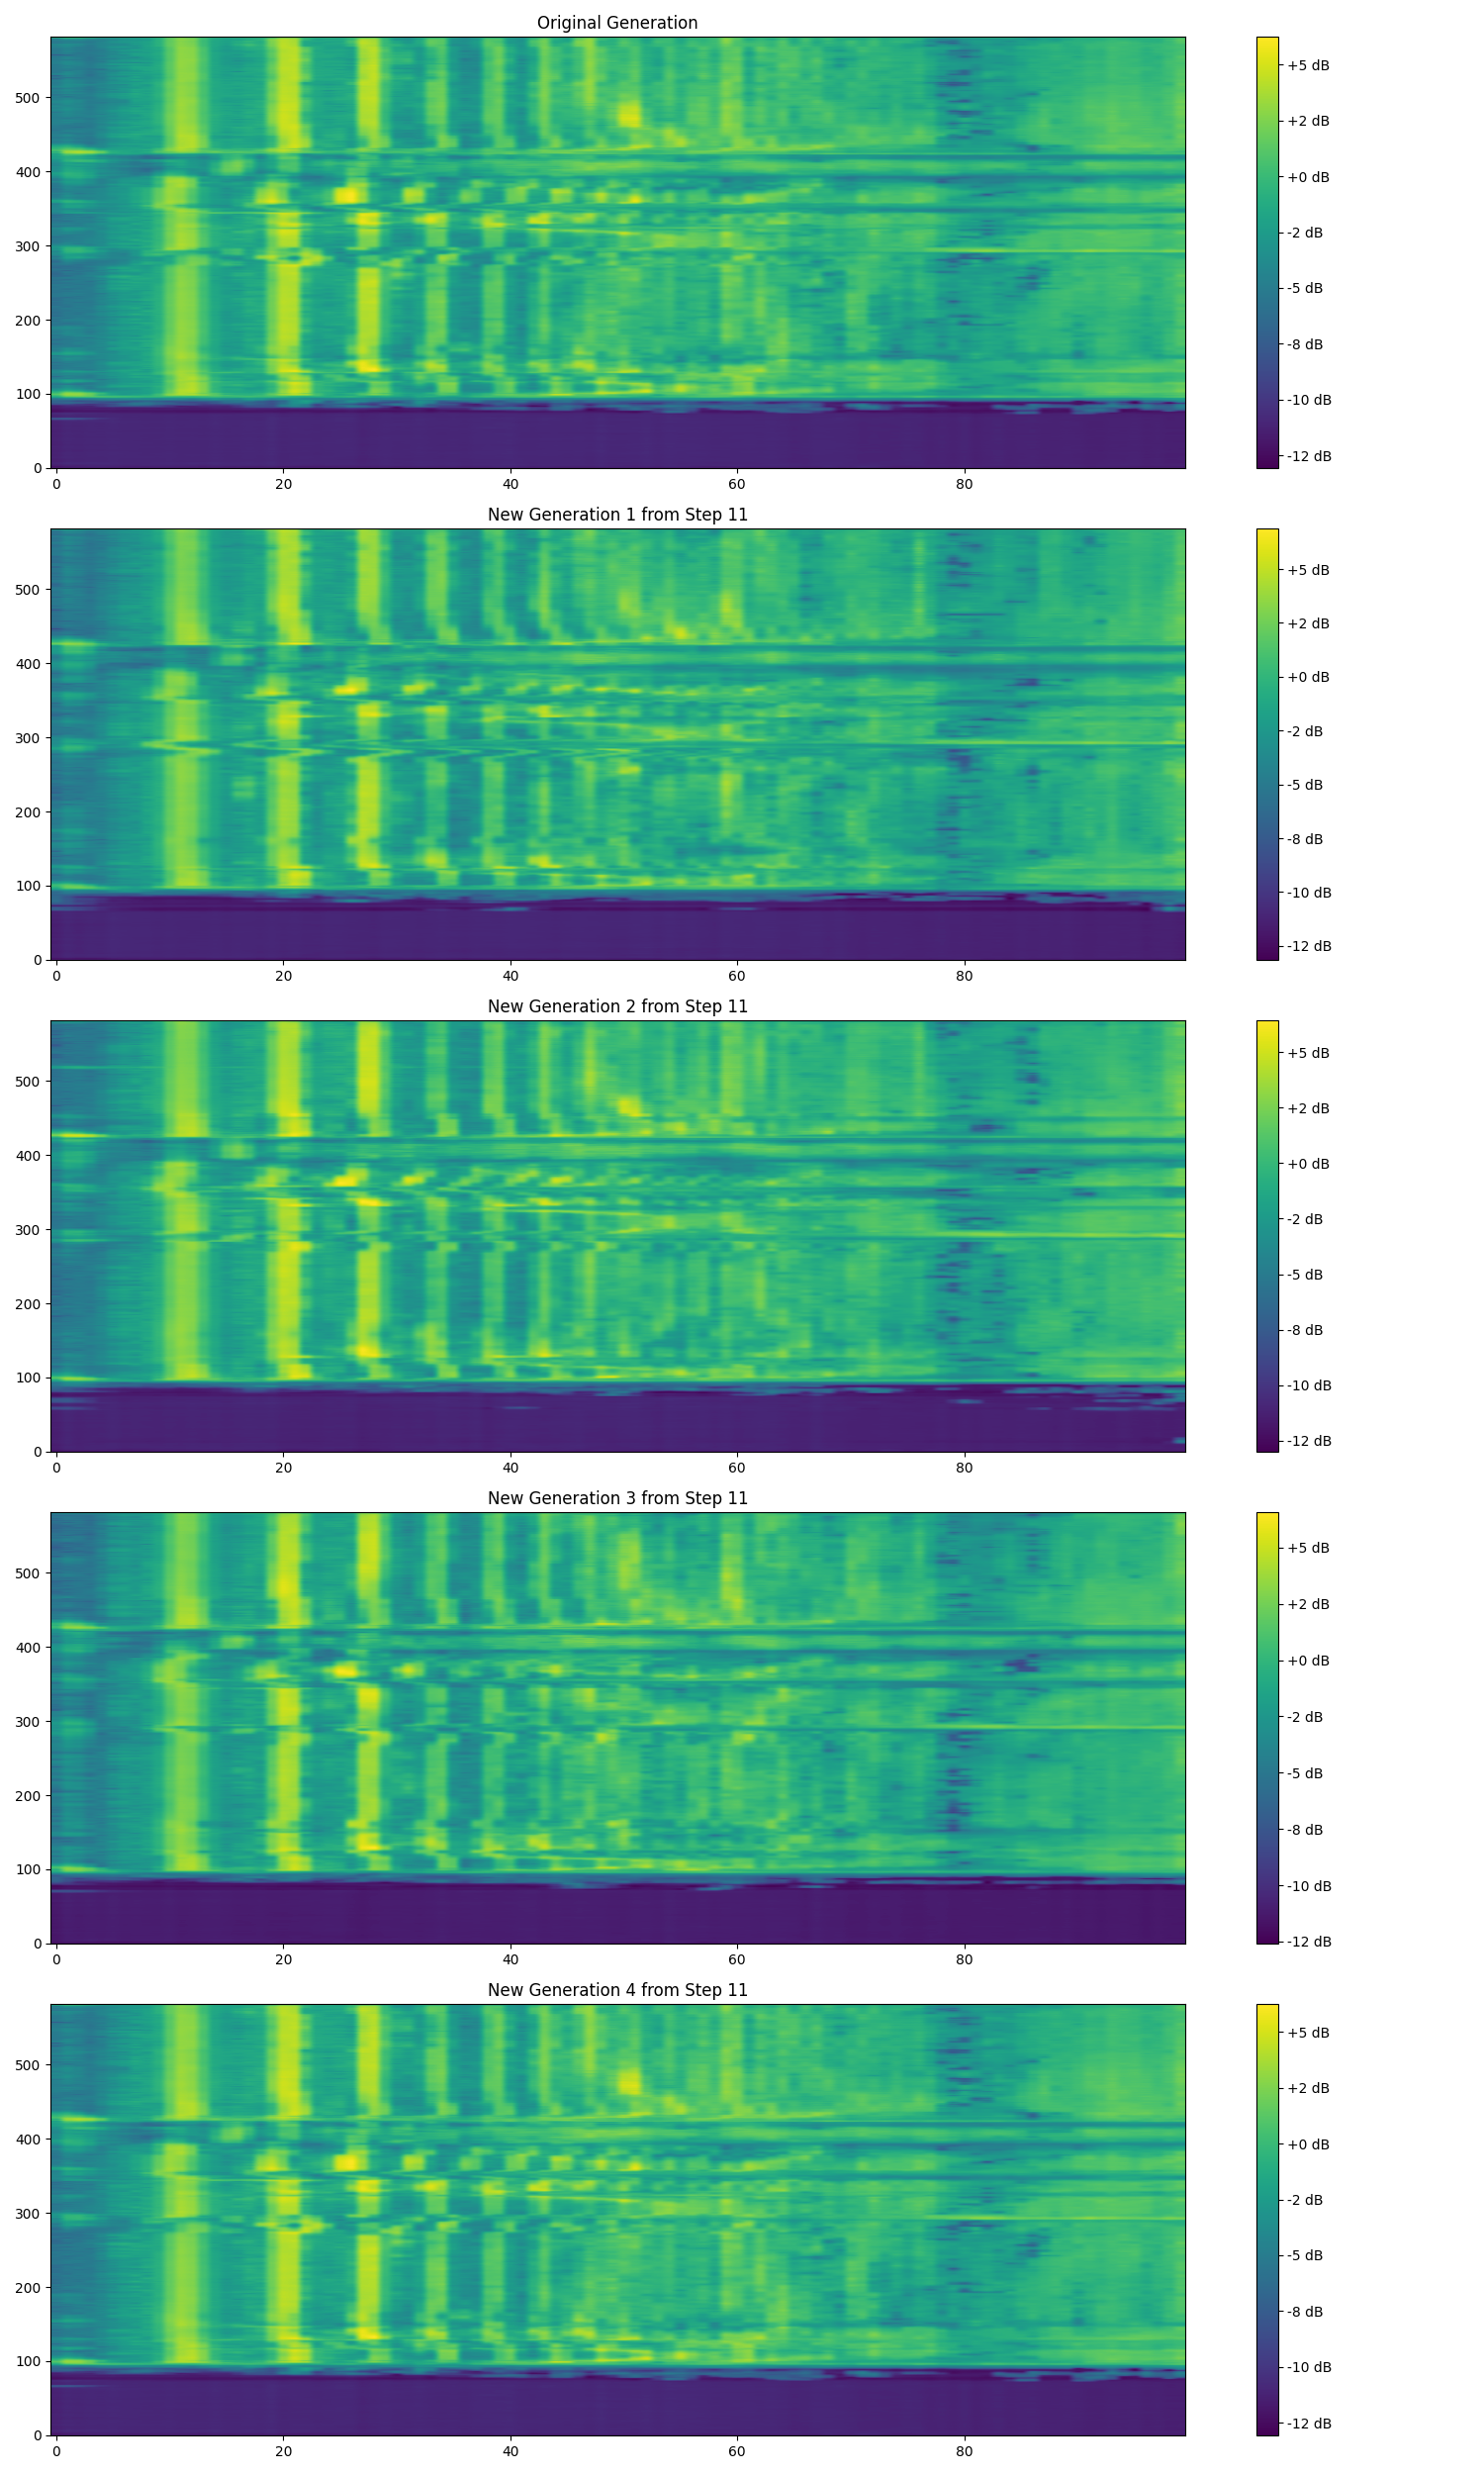

In [18]:
# Cell 8 - Trajectory analysis and noise manipulation

import torchaudio
import torch
import soundfile as sf
from pathlib import Path
from IPython.display import display, Audio, Image
import matplotlib.pyplot as plt

# Constants
N_Step_intermediate = 11  # The step at which we'll interrupt the trajectory
N_New_samples = 4        # Number of new samples to generate
speed = 0.7

# Get reference audio and process it
main_voice = {"ref_audio": ref_audio, "ref_text": ref_text}
ref_audio_preprocessed, ref_text_preprocessed = preprocess_ref_audio_text(
    main_voice["ref_audio"], 
    main_voice["ref_text"], 
    # end_time=ref_end_time,
    clip_short=False,
    bypass_cache=True
)

# Get reference audio length
audio, sr = torchaudio.load(ref_audio_preprocessed)
ref_audio_len = audio.shape[-1] // hop_length

# 1. Generate initial trajectory
print("Generating initial trajectory...")
audio, sr, mel_spec, trajectory = infer_single_process(
    ref_audio_preprocessed, 
    ref_text_preprocessed, 
    gen_text, 
    ema_model, 
    vocoder,
    mel_spec_type=mel_spec_type,
    nfe_step=32,
    speed=speed,
    cfg_strength=3.0
)

# 2. Take trajectory element at N_Step_intermediate
intermediate_state = trajectory[N_Step_intermediate]

# 3. Remove noise using the schedule
noise_scale = get_noise_schedule(N_Step_intermediate, len(trajectory))
initial_noise = trajectory[0]
cleaned_state = intermediate_state - initial_noise * noise_scale

# 4 & 5. Create N_New_samples copies with new noise
noisy_states = []
shape = intermediate_state.shape
dtype = intermediate_state.dtype
device = intermediate_state.device

torch.manual_seed(42)  # For reproducibility
for i in range(N_New_samples):
    new_noise = torch.randn(shape, device=device, dtype=dtype)
    noisy_state = cleaned_state + new_noise * noise_scale
    noisy_states.append(noisy_state)

# 6. Complete generation for each noisy state
print(f"\nGenerating {N_New_samples} new samples from intermediate state...")
final_samples = []
for i, noisy_state in enumerate(noisy_states):
    print(f"Generating sample {i+1}/{N_New_samples}")
    audio, sr, mel_spec, new_trajectory = infer_single_process(
        ref_audio_preprocessed,
        ref_text_preprocessed,
        gen_text,
        ema_model,
        vocoder,
        mel_spec_type=mel_spec_type,
        nfe_step=32,
        speed=speed,
        cfg_strength=3.0,
        start_step=N_Step_intermediate + 1,
        initial_state=noisy_state
    )
    final_samples.append((audio, mel_spec))

# 7. Visualize and play results
plt.figure(figsize=(15, 5 * (N_New_samples + 1)))

# Plot original mel spectrogram
plt.subplot(N_New_samples + 1, 1, 1)
plt.imshow(mel_spec.T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Generation')
display(Audio(audio, rate=sr))

# Plot and play new generations
for i, (sample_audio, sample_mel) in enumerate(final_samples):
    plt.subplot(N_New_samples + 1, 1, i + 2)
    plt.imshow(sample_mel.T, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'New Generation {i+1} from Step {N_Step_intermediate}')
    display(Audio(sample_audio, rate=sr))

plt.tight_layout()
spec_path = Path(output_dir) / "multiple_generations.png"
plt.savefig(spec_path)
plt.close()

display(Image(filename=spec_path))